Aim: Want to compute the hedging profile in the BSM model where the position is long a call option.

Set the space up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# from pylab import *

import mpmath as mp

from scipy import integrate
from scipy import optimize

from tqdm import tqdm

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amssymb}')

from IPython.display import display, Latex

mpl.rcParams['figure.figsize'] = [8, 4]

#from numba import jit

from datetime import datetime


s = datetime.now().strftime("%Y%m%d%H%M%S")
plot_folder = "figures/"+s+"/"

import os

# Check whether the specified path exists or not
isExist = os.path.exists(plot_folder)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(plot_folder)



Set the parameters:
- `S0` is the initial asset price
- `sigma` is the volatility
- `K` is the strike of the call
- `w` is the initial wealth
- `T` is the maturity time
- `r` is the interest rate
- `theta` is the Sharpe ratio
- `alpha` is the minimum wealth level
- `DC` is the difference between the price of the call and the model price (DC>0 implies call price too high)
- `p` is the power in the utility function, $u_p(x) = x^{p}(1-p)^{-1}$. NB: $0<p<1$.

In [2]:
S0 = 1.2
sigma = 0.5
#sigma = 0.15
K = 0.85
w = 0.1
T = 2
r = 0.01
alpha = 0.4
DC = 0.02
p = 0.75
# theta = p*sigma/2
theta = 0.05

# May want to pass parameter set for ease.
s = {'S0': S0, 'sigma': sigma, 'K': K, 'w': w, 'T': T, 'r': r, 
     'alpha': alpha, 'DC': DC, 'p': p, 'theta': p*sigma/2}

display(Latex(f'$(\\sigma-\\theta/p)$: {sigma-theta/p}')) # Should be >= 0.

if sigma-theta/p < 0:
    display(Latex('Warning: Should have (\\sigma-\\theta/p) \ge 0'))

display(Latex(f'$\\theta$: {theta}'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Find the price of the Call option; implement BS pricing.

In [3]:
from scipy.stats import norm

def BS(K,S0,sigma,r,T):
    d1 = (np.log(S0/K)+(r+0.5*sigma*sigma))/sigma/np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d1-sigma*np.sqrt(T))

def BS2(s):
    return BS(s['K'], s['S0'], s['sigma'], s['r'], s['T'])

Find the BS price of the call

In [4]:
c_BS = BS(K,S0,sigma,r,T) # Using parameter input
c_BS2 = BS2(s)            # Using dictionary input

if c_BS != c_BS2:
    print("Warning: pricing error")
else:
    display(Latex(f'Black-Scholes price of a call: {c_BS}'))


<IPython.core.display.Latex object>

We first consider the question of whether, for given constants, there exists a feasible hedging strategy for the call option with given data. To see this, we recall that a necessary condition for the existence of a feasible portfolio holding exactly $\lambda$ units of the option, with complete hedging, is that:
$$
z(0,\lambda) \le w_0 +\lambda \Delta c.
$$
Since $z(0,\lambda) = \lambda \rho(0) - \alpha \phi(0)$, we can rewrite this as
$$
\lambda \left( \rho(0) - \Delta c \right) \le w_0 + \alpha \phi(0).
$$
This happens either if $\rho(0) \le \Delta c$ or if $\rho(0) > \Delta c$ and $\lambda \le \frac{w_0 + \alpha \phi(0)}{\rho(0) - \Delta c}$.

We will later find the upper bound in terms of the value of the root of a specific integral equation.

We first determine the function $\phi(u)$, which is the value of $\phi_u = \xi^{-1}_u D_u^{-1}$ at time $u$ if $S_u^D = K^D$.

We can implement functions to find:
$$
    \rho(t) = \mathbb{E}^{\overline{\mathbb{Q}}}\left[\int_t^T \phi_s \, d L_s^{S_D,K_D}\big| S_t^D = K^D\right]
    $$
and
$$
    \phi(t) = \left( \frac{S_0}{K^D}\right)^{\frac{\theta}{\sigma p}} \exp\left\{ \frac{\theta}{2p^2} \left( \theta-\sigma p\right)t\right\}.
$$

In [5]:
def phi(t):
    return np.exp(theta/(p*sigma)*np.log(S0/(K*np.exp(-r*T)))
                  +theta*t*(theta/p-sigma)/p/2.0)

def rho(t):
    return np.exp(-r*t)*K*(2*norm.cdf(sigma*np.sqrt(T-t)/2)-1)*phi(t)


We can now compute the maximum feasible value of $\lambda$ where the intermediate wealth constraint means simple hedging is possible.

In [6]:
# Find the minimum value of lambda which is feasible.

if rho(0) < DC:
    display(Latex(f"Warning: $\delta c$ too big: any $\lambda$ is feasible."))
else:
    max_lam = (w + alpha*phi(0))/(rho(0)-DC)
    display(Latex(f"Maximum Feasible $\lambda$: {max_lam}"))



<IPython.core.display.Latex object>

In [7]:
# Fix a choice of lambda for calculations below.

lam = 2.46

print("Lambda: ", lam)



Lambda:  2.46


Plot the functions $\phi(t)$ and $\rho(t)$. Note: should both be decreasing in $t$ (in particular, need $\theta>0$ and $p \sigma > \theta$). 

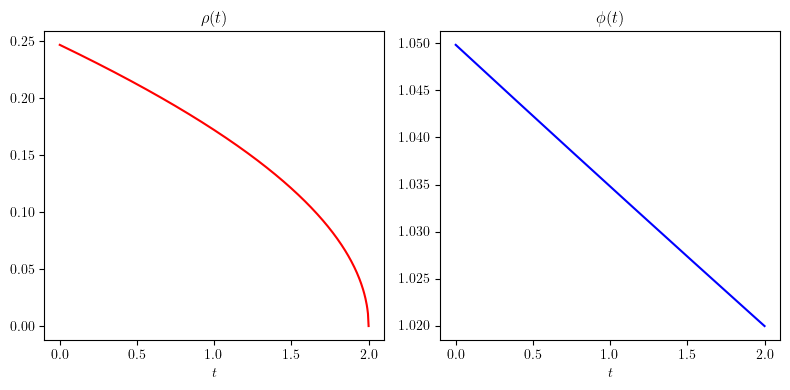

In [8]:
N = 500
t = np.linspace(0,T,N+1)

#fig = plt.figure()
#axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#axes.plot(t, rho(t) , 'r', t, phi(t), 'b', t[:N], psi(t[:N],0.5), 'g')

plt.subplot(1,2,1)
plt.plot(t, rho(t), 'r')
plt.title(r'$\rho(t)$')
plt.xlabel(r'$t$')

plt.subplot(1,2,2)
plt.plot(t, phi(t), 'b')
plt.title(r'$\phi(t)$')
plt.xlabel(r'$t$')

# m0 = 0.5
# plt.subplot(1,3,3)
# plt.plot(t[:N], psi(t[:N],m0), 'g')
# plt.xlabel(r'$t$')

# plt.title(r'$\psi_t(m)$, $m=$'+str(m0))
    
plt.tight_layout()
plt.savefig(plot_folder+"RhoPhi.pdf", bbox_inches='tight')
plt.show()



Define a function $z$ given by $z(t) = \lambda \rho(t) - \alpha \phi(t)$.

In [9]:
def z_vec(u,lam):
    return lam*rho(u)-alpha * phi(u)

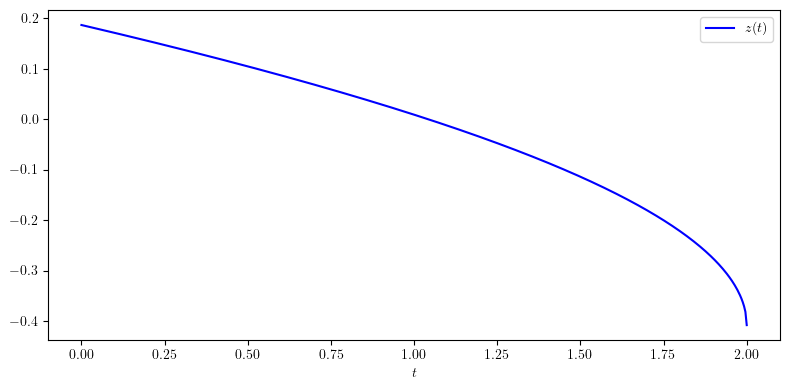

In [10]:
# Plot z function

z = z_vec(t,lam)
plt.plot(t,z,'b',label=r'$z(t)$')
plt.xlabel(r'$t$')

plt.legend()

plt.tight_layout()
plt.savefig(plot_folder+"z.pdf", bbox_inches='tight')

plt.show()




Now want to try and compute the optimal wealth. The difficulty is in computing the hitting density of the critical value. In the case where $\theta = p \sigma /2$, then we can use the laws of hitting times which are derived from the relection principle. In general, we can use an inverse Laplace transform (but this may be more numerically intensive, so we handle this case separately).

In [11]:
simple_case = False

if simple_case:
    theta = p*sigma/2
    x0 = np.log(S0)/sigma
    y0 = (np.log(K)-r*T)/sigma
    a0 = x0-y0
    beta = 0 # Assumed in gamma_2.
    # beta = 0, not needed...
else:
    if theta==p*sigma/2:
        print("Warning: use simple case")
    x0 = np.log(S0)/sigma
    y0 = (np.log(K)-r*T)/sigma
    beta = sigma/2 - theta/p
    a0 = x0-y0
    #     a0 = np.log(K/S0)/sigma
    #     b0 = theta*sigma/p-sigma**2/2
    h = lambda z: mp.exp(-a0*beta-a0*mp.sqrt(beta**2+2*z)*mp.sign(a0))

print("(x0, y0, beta): ",(x0,y0,beta))

print("Theta: ",theta)

(x0, y0, beta):  (0.3646431135879092, -0.36503785899554986, 0.18333333333333335)
Theta:  0.05


Implement hitting law for $y$ given start at $x > y$, for BM. Specifically, for the Brownian motion $B$ started at $x$, and the stopping time 
$$H^\beta_y := \inf \{ t \ge 0: x + B_t = y + \beta t\}$$
where we typically take $x = \log(S_0)/\sigma$, $y = \log(K^D)/\sigma$ and $\beta = \sigma/2 - \theta/p$,
then we can define $\gamma_0, \gamma_1^\beta, \gamma_2^\beta$ by:
$$ \mathbb{P}_x(B_t \in A) = \int_A \gamma_0(t,x,y) \, dy, \quad \mathbb{P}_x(H_y \lt t) = \int_0^t \gamma_1^\beta(u,x,y) \, du,$$
and also
$$\mathbb{P}_x(H_y > t, B_t \in A) = \int_{z \in A} \gamma_2^\beta(t,x,y,z) \, dz.$$

Note moreover that we have $\mathbb{P}_x(H_y > t, B_t \in A) = \mathbb{P}_x(B_t \in A) - \mathbb{P}_x(H_y \le t, B_t \in A)$, so we can also compute
$$
\gamma_2^\beta(t,x,y,z) = \gamma_0(t,x,z) - \int_0^t \gamma_1^\beta(u,x,y) \gamma_0(t-u,y + \beta u,z) \, du.
$$


In [12]:
def gamma(t,x,y):
    if simple_case:
        return (x-y)*norm.pdf((y-x)/(np.sqrt(t)))/np.power(t,3/2)
    else:
        return np.frompyfunc(lambda t1: 
                             mp.invertlaplace(h,t1,method='talbot'),1,1)

gamma0 = lambda t, x, y: norm.pdf((y-x)/np.sqrt(t))/np.sqrt(t)

if simple_case:
    def gamma1(t,x,y):
        return np.abs(y-x)*norm.pdf(np.abs(y-x)/np.sqrt(t))/np.power(t,3/2)
else:
    def h0(x,y):
        return lambda z: mp.exp(-(x-y)*beta-(x-y)*mp.sqrt(beta**2+2*z)*mp.sign(x-y))
    def gamma1(t,x,y):
        return np.frompyfunc(lambda tt: 
                             mp.invertlaplace(h0(x,y),tt,method='talbot'),1,1)(t)
    

In [13]:
gamma1(t[1],x0,y0)

mpf('6.1913135869098136e-27')

0.524365844521218


<Figure size 800x400 with 0 Axes>

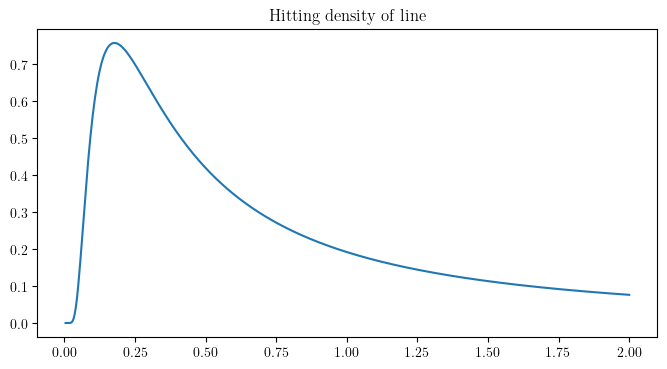

<Figure size 800x400 with 0 Axes>

In [14]:
g1 = gamma1(t[1:],x0,y0)
plt.plot(t[1:],g1)
print(np.sum(g1)*(t[3]-t[2]))
plt.title("Hitting density of line");

plt.figure()


Want to compute the law of the terminal wealth, and the utility. We first need to find the optimal choice of $M$ for the initial wealth and the price gap, $\Delta C$, i.e.
where $M$ is chosen such that $$H(M) := \mathbb{E}^{\bar{\mathbb{Q}}}\left[{\left( \sup_{0 \le u \le T} J_u^\zeta\right) \vee M}\right] = w_0 + \lambda\Delta C.$$

We recall the formula:
$$
\begin{align}
        \mathbb{E}^{\bar{\mathbb{Q}}}\left[{\left( \sup_{0 \le u \le T} J_u^\zeta\right) \vee M}\right] 
        & = M + \int_0^T \gamma_1^\beta(u,x,y)  (z(u; \lambda) - M)_+  \, \mathrm{d} u \nonumber \\
        & = M + \int_0^{r^*(M;\lambda)} \gamma_1^\beta(u,x,y)  (z(u; \lambda) - M) \, \mathrm{d} u \nonumber
\end{align}
$$
where we recall
$$
    z(u) := z(u;\lambda) := \lambda \rho(u) - \alpha \phi(u)
$$
and
$$
    r^*(M;\lambda) := \inf\left\{ u < T : z(u; \lambda) < M\right\} \wedge T.
$$


We write in particular:
$$
\begin{align}
H(M,\lambda) & := M + \int_0^T \gamma_1^\beta(u,x,y)  (z(u; \lambda) - M)_+  \, \mathrm{d} u  
\end{align}
$$
then the optimal choice of $M$ for fixed $\lambda$ is given by solving: $H(M,\lambda) = w_0 + \lambda \Delta C$. Moreover, a given choice of $\lambda$ can only be feasible if $H(0,\lambda) \le w_0 + \lambda \Delta C$. Otherwise we have no feasible choice of $M$ which guarantees non-negative a.s. terminal wealth and satisfies the path-constraint.

More generally, setting $H^*(M,\lambda):= H(M,\lambda)-w_0-\lambda \Delta C$, we are looking for roots of $H^*(M,\lambda)$.

In [15]:
target = (w + lam*DC)

def phi_tilde(u,t):
    return np.exp(-theta/p*u-theta**2/p**2*t/2)

def H(M,lam, target):
    return M + integrate.quad_vec(lambda t: gamma1(t,x0,y0)
                                  *np.maximum(z_vec(t,lam)-M,np.zeros(np.shape(t))),
                                  0,T,epsabs=1.e-03, epsrel=1.e-03)[0] - target
       
HH = H(0.,lam, target)

if HH > 0:
    display(Latex(f"Warning: $H^*(M=0,\lambda) > 0! No feasible solution."))
    display(Latex(f"$H^*(M=0,\lambda):$ {H(0.,lam, target)}"))
else:
    display(Latex(f"$H^*(M=0,\lambda):$ {H(0.,lam, target)}"))

<IPython.core.display.Latex object>

Note that when $H^*(M=0,\lambda)$ is positive, we are in the case where there is insufficient wealth to guarantee a non-negative terminal wealth. There may still be a trading strategy which satisfies the pathwise admissibility constraint, but not the constraint which requires the terminal wealth to be non-negative.  

Find true value of $M$ by binary search

In [16]:
M_R = target

H_R = H(M_R,lam,target)
print(H_R)
print(M_R)


0.00151379462251547
0.1492


In [17]:

M_L = 0.
H_L = H(M_L,lam,target)
print(H_L)
print(M_L)


-0.102208568208848
0.0


In [18]:
if H_R <= 0:
    print("Up to computational accuracy, no hedging required.")
    print(M_R)
else:
    while H_L > 0:
        M_L = np.minimum(-0.1,2.*M_L)
        print(M_L)
        H_L = H(M_L,lam,target)
        print("H: ",H_L)

    xtol = 1.e-4
    rtol = 1.e-4

    M_mid = (M_L + M_R)/2.
    H_mid = H(M_mid,lam,target)
    print("M: ", M_mid, "H: ", H_mid)
    while np.abs(H_R-H_L) > xtol and np.abs(H_mid) > rtol:
        if H_mid > 0:
            M_R = M_mid
            H_R = H_mid
        else:
            M_L = M_mid
            H_L = H_mid
        M_mid = (M_L + M_R)/2.
        H_mid = H(M_mid,lam,target)
        print("M: ", M_mid, "H: ", H_mid)



M:  0.0746 H:  -0.0554258667544452
M:  0.1119 H:  -0.0288356855158171
M:  0.13055 H:  -0.0142579101116679
M:  0.139875 H:  -0.00654117398341372
M:  0.14453749999999999 H:  -0.0025587043649194
M:  0.14686875 H:  -0.000533887622059387
M:  0.148034375 H:  0.000487248648881805
M:  0.1474515625 H:  -2.41760991104845e-5


We now compare this with the following characterisation of the solution $M$. Specifically, we claim $M$ is also given as the solution to the equation:
$$
w_0 + \lambda \Delta C  = M + \int_0^{r^*(M;\lambda)} \gamma_1^\beta(u,x,y)  (z(u; \lambda) - M) \, \mathrm{d} u
$$

Here $r^*(M):= \inf \{ u < T : z(u) < M\}$.

For a given value of $\lambda, M$, we can compute $r^*(M;\lambda)$ effectively via a search algorithm. 

r_star:  0.2984619140625


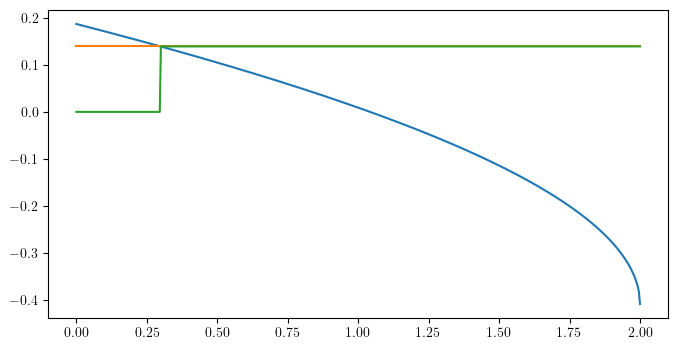

In [19]:
# Choose a value of $M$ which is close to the answer above.

# We look for the value r^*(M) through a search algorithm

M = 0.139


r_star = optimize.bisect(lambda x: z_vec(x,lam) - M,0,T,xtol=1.e-4,rtol=1.e-4)

plt.plot(t,z_vec(t,lam),t,np.ones(np.shape(t))*M,t,M*(t>r_star));


def r_star(M,lam):
    if z_vec(T-0.000001,lam) >= M:
        return T
    elif z_vec(0,lam) <= M:
        return 0
    else:
        return optimize.bisect(lambda x: z_vec(x,lam) - M,0,T,xtol=1.e-4,rtol=1.e-4)

print("r_star: ", r_star(M,lam))

plt.show()

In [20]:
# Implement code to find $M$ for given $lambda$ using H. Start with a range of lambdas

def findM(lam,xtol = 1.e-6, rtol = 1.e-6, debug=False, M_min_factor = 10.):
    target = w + lam*DC
    M_R = target
    M_L = -target

    H_R = H(M_R,lam,target)
    if H_R < 0:
        print("Warning: no stochastic effects to numerical tolerance.")
        return M_R

    H_L = H(M_L,lam,target)
    while H_L > 0:
        print("M_L: ",M_L, "H_L: ", H_L)
        if M_L < -M_min_factor*target:
            print("Unable to find M. May be - infinity.")
            return M_L
        M_L = 2*M_L
        H_L = H(M_L,lam,target)

    M_mid = (M_L + M_R)/2.
    H_mid = H(M_mid,lam,target)
    if debug:
        print("M: ", M_mid, "H: ", H_mid)
    while np.abs(H_R-H_L) > xtol and np.abs(H_mid) > rtol:
        if H_mid > 0:
            M_R = M_mid
            H_R = H_mid
        else:
            M_L = M_mid
            H_L = H_mid
        M_mid = (M_L + M_R)/2.
        H_mid = H(M_mid,lam,target)
        if debug:
            print("M: ", M_mid, "H: ", H_mid)
    return M_mid



findM(lam,debug=True)

eps = 0.00005

# lam_vec = np.linspace(crit_lam+eps,max_lam-eps,30)
# lam_vec = np.linspace(crit_lam+eps,4.0,30)
lam_vec = np.linspace(2.0,4.0,100)

M_vec = np.zeros(np.size(lam_vec))
r_star_vec = np.zeros(np.size(lam_vec))

for i in tqdm(range(np.size(lam_vec))):
    M_vec[i] = findM(lam_vec[i])
    r_star_vec[i] = r_star(M_vec[i],lam_vec[i])


M:  0.0 H:  -0.102208568208848
M:  0.0746 H:  -0.0554258667544452
M:  0.1119 H:  -0.0288356855158171
M:  0.13055 H:  -0.0142579101116679
M:  0.139875 H:  -0.00654117398341372
M:  0.14453749999999999 H:  -0.0025587043649194
M:  0.14686875 H:  -0.000533887622059387
M:  0.148034375 H:  0.000487248648881805
M:  0.1474515625 H:  -2.41760991104845e-5
M:  0.14774296874999998 H:  0.000231436576471566
M:  0.14759726562499997 H:  0.000103530540266433
M:  0.1475244140625 H:  3.95775221639083e-5
M:  0.14748798828124998 H:  7.69613296247584e-6
M:  0.147469775390625 H:  -8.23998307397655e-6
M:  0.1474788818359375 H:  -2.71925055750355e-7


100%|██████████| 100/100 [26:24<00:00, 15.85s/it]


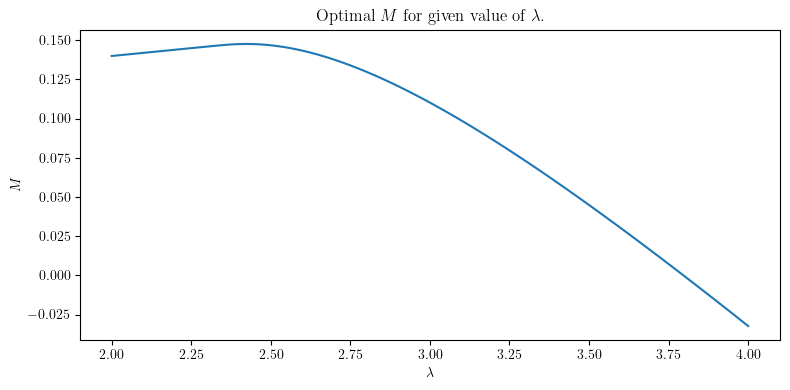

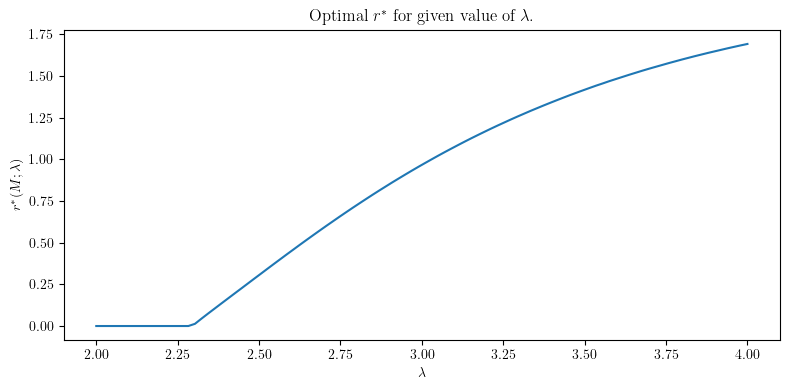

Largest value of lambda with non-negative terminal wealth:  3.7777777777777777


In [21]:

plt.plot(lam_vec,M_vec)

plt.xlabel(r"$\lambda$")
plt.ylabel(r"$M$")
plt.title(r"Optimal $M$ for given value of $\lambda$.")

plt.tight_layout()
plt.savefig(plot_folder+"M_vs_lambda.pdf", bbox_inches='tight')

plt.show()

plt.plot(lam_vec,r_star_vec)

plt.xlabel(r"$\lambda$")
plt.ylabel(r"$r^*(M;\lambda)$")
plt.title(r"Optimal $r^*$ for given value of $\lambda$.")

plt.tight_layout()
plt.savefig(plot_folder+"r_star_vs_lambda.pdf", bbox_inches='tight')

plt.show()

max_lam_positive = np.max(lam_vec[M_vec>0])

print("Largest value of lambda with non-negative terminal wealth: ", max_lam_positive)

    

Note that the plot above allows negative values of $M$. Such choices will give rise to portfolios which have negative final wealth with positive probability. To avoid this situation, we now only consider cases where $M\ge 0$.

We now look to compute the utility of terminal wealth, for given $\lambda, M$. We recall that the utility is given by:
$$
\mathbb{E}\left[{u_p(W_T^{\pi,C})}\right] = c_p \cdot \left( u_p(M) + \int _0^{r^*(M;\lambda)} \gamma_1^\beta(s,x,y) \left\{u_p(z(s;\lambda))-u_p(M)\right\} \, \mathrm{d} s\right)
$$
where $c_p = \left(\mathbb{E}\left[H_T^{1-\frac{1}{p}}\right]\right)^{-p}$.

Since the constant $c_p$ is independent of the choice of $M$ and $\lambda$, we can ignore this for comparison purposes and only compute the term inside the large brackets.

First we note that we can compute the CDF of the terminal wealth under the transformed measure $\bar{\mathbb{Q}}$ using the fact that:
$$
\bar{\mathbb{Q}}\left(\bar{Y}_T \le x\right) = \bar{\mathbb{Q}}\left(M \vee \sup_{0 \le u \le T} J_u^\zeta \le x\right) = 
\begin{cases}
0 & \text{if } x < M \\
1-\int_0^T \gamma_1^\beta(u,x,y) \mathbf{1}_{\{z(s;\lambda) > x\}} \, \mathrm{d} u & \text{if } M \le x
\end{cases}.
$$


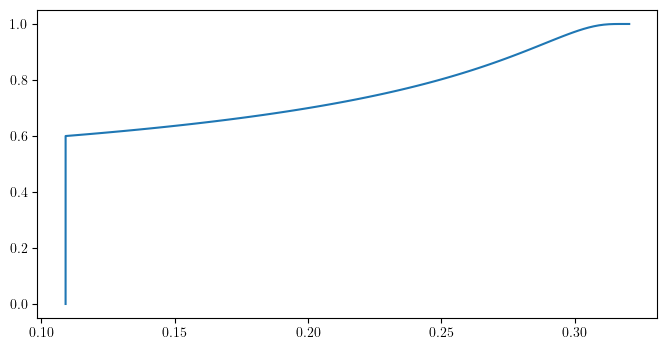

In [22]:
# Compute CDF of \bar{Y}_T.

n0 = int(np.floor(np.size(lam_vec)/2))

lam0 = lam_vec[n0]
r_star0 = r_star_vec[n0]
M0 = M_vec[n0]

t0 = np.linspace(0,r_star0,100)
p_vec = np.zeros(np.size(t0[1:]))
z0 = z_vec(t0[1:],lam0)



for tt in range(np.size(t0)-1):
    p_vec[tt] = integrate.quad_vec(lambda t: gamma1(t,x0,y0),0,t0[tt+1],epsabs=1.e-03, epsrel=1.e-03)[0]

eps2 = 0.00001

z0 = np.append(z0,z0[-1]-eps2)
p_vec = np.append(p_vec,1)


plt.plot(z0,1-p_vec)

100%|██████████| 74/74 [42:34<00:00, 34.52s/it]


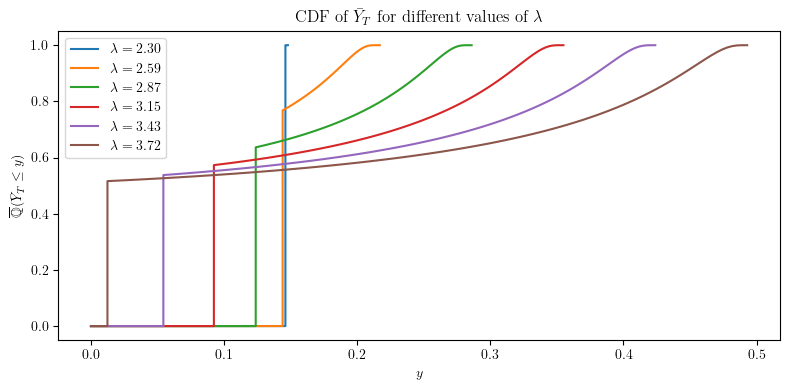

In [23]:
# Repeat for multiple values of lambda.
# Exclude indices with r_star = 0.

idx = np.where((M_vec>0) & (r_star_vec>0))
NN = np.size(idx)

lamN = lam_vec[idx]
r_starN = r_star_vec[idx]
MN = M_vec[idx]

tN = np.zeros((NN,100))
pN = np.zeros((NN,99))
zN = np.zeros((NN,99))


for n in tqdm(range(NN)):
    tN[n,:] = np.linspace(0,r_starN[n],100)
    zN[n,:] = z_vec(tN[n,1:],lamN[n])
    for tt in range(np.size(tN[n])-1):
        pN[n,tt] = integrate.quad_vec(lambda t: gamma1(t,x0,y0),0,tN[n,tt+1],epsabs=1.e-03, epsrel=1.e-03)[0]

zN = np.append(zN,np.reshape(zN[:,-1]-eps2,(NN,1)),axis=1)
zN = np.append(zN,np.zeros((NN,1)),axis=1)

pN = np.append(pN,np.ones((NN,1)),axis=1)
pN = np.append(pN,np.ones((NN,1)),axis=1)
pN = 1-pN

step_size = NN//5

for i in np.arange(0,NN,step_size):
    plt.plot(zN[i],pN[i])

plt.xlabel(r"$y$")
plt.ylabel(r"$\overline{\mathbb{Q}}(\bar{Y}_T \leq y)$")
plt.title(r"CDF of $\bar{Y}_T$ for different values of $\lambda$")
plt.legend([r"$\lambda={0:.2f}$".format(lamN[i]) for i in np.arange(0,NN,step_size)])

plt.tight_layout()

plt.savefig(plot_folder+"CDF_YT.pdf", bbox_inches='tight')


In [24]:
# Utility Function
def u(x):
    return np.power(x,p)/(1-p)

def u_inv(x):
    return np.power((1-p)*x,1/p)

# Compute utility:
# NB: Note that this is missing a scaling factor. See paper.
# The negative sign is due to the fact that p is decreasing 
#   since z is also decreasing from the way we have constructed it.

def Exp_u(z,p):
    return -np.dot(np.diff(p),(u(z[:-1])+u(z[1:]))/2)

display(Latex(f"Expected utility: {Exp_u(zN[5,:],pN[5,:])} for $\lambda$ = {lamN[5]}"))

display(Latex(f"Expected utility: {Exp_u(zN[5,:],pN[5,:])} for $\lambda$ = {lamN[5]}"))
display(Latex(
    f"Certain equivalent: {u_inv(Exp_u(zN[5,:],pN[5,:]))} for $\lambda$ = {lamN[5]}. "
    f"For comparison, no trading gives {w}"
))




<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Want to express the utility as a function of e.g. $\lambda$, $\Delta C$, ...

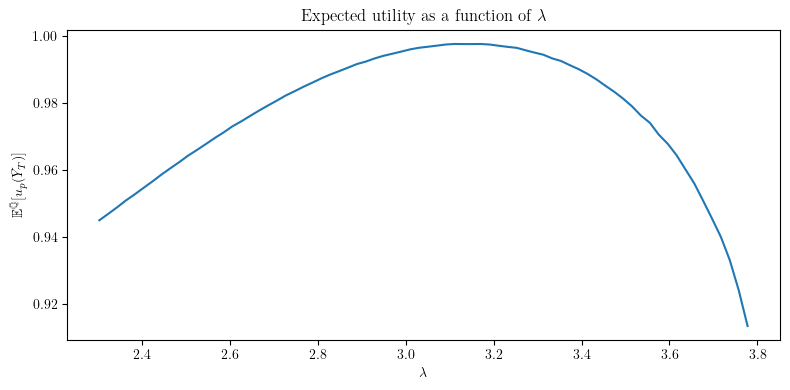

<IPython.core.display.Latex object>

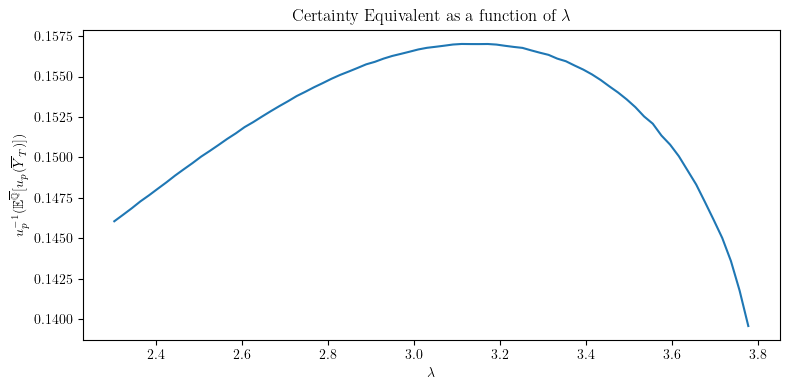

In [25]:
uN = np.zeros(NN)

for i in range(NN):
    uN[i] = Exp_u(zN[i,:],pN[i,:])

plt.plot(lamN,uN)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\mathbb{E}^{\bar{\mathbb{Q}}}[u_p(\bar{Y}_T)]$")
plt.title(r"Expected utility as a function of $\lambda$")
plt.tight_layout()
plt.savefig(plot_folder+"ExpectedUtility.pdf", bbox_inches='tight')
plt.show()

# Find Maximum value

idx_max = np.argmax(uN)
lam_max = lamN[idx_max]
u_max = uN[idx_max]
display(Latex(f"Maximum expected utility: {u_max} for $\lambda$ = {lam_max}"))

# Plot certainty equivalent
plt.figure()

plt.plot(lamN,u_inv(uN))
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$u_p^{-1}(\mathbb{E}^{\overline{\mathbb{Q}}}[u_p(\overline{Y}_T)])$")
plt.title(r"Certainty Equivalent as a function of $\lambda$")
plt.tight_layout()
plt.savefig(plot_folder+"CertaintyEquivalent.pdf", bbox_inches='tight')
plt.show()



## Optimal Hedging of One touch Call Option

# No semi-static hedge

Now consider the addition of a one-touch call option to the portfolio. This is a call option which pays out $1$ if the asset price (carried forward to maturity time $T$) hits a certain level $B$ before maturity, and $0$ otherwise.

We suppose the trader holds a short position in the one-touch call option, with strike $B$ and maturity $T$. We write the payoff of the one-touch call option as $C_T^o = \mathbf{1}_{\{\exists t \in [0,T]: S_t \ge B D_t^{-1} D_T\}}$. Write $H_B = \inf \{ t \in [0,T]: S_t D_t^{-1} D_T \ge B\}$ for the hitting time of the barrier $B$ by the process $S_t D_t^{-1} D_T$.

In the first case, we suppose that the trader holds only the short position, plus dynamic trading of the underlying asset. In this case, we can compute the intrinsic value of the one-touch call option at time $t \le T$ as:
$$
\mathcal{I}_t(-C_T^o) =
\begin{cases}
-\frac{S_t}{B} & \text{if } t < H_B \wedge T\\
-1 & \text{if } H_B \wedge T \le t \le T\\
0 & \text{if } t = T < H_B
\end{cases}.
$$

It follows from this that we get the decomposition:
$$
\zeta^0_t = \mathbb{E}^{\overline{\mathbb{Q}}}\left[\sup_{t \le u \le T} J_u^\zeta\big| \mathcal{F}_t\right],
$$
where
$$
J_t^\zeta = 
\begin{cases}
(\xi_T D_T)^{-1} \left( \frac{S_T}{B}-\alpha\right)_+ & \text{if } T- < H_B\\
0 & \text{if } H_B \wedge T \le t \le T\\
-\infty & \text{otherwise}
\end{cases}.
$$

For the analysis in this case, we use $\lambda = 1$, and do not vary the number of units of the one-touch option held. We will also allow the trader later to buy and sell vanilla call options at the fair market price.

We fix the parameter $B$, which is the barrier level, below. Need $B > S_0/D_T$.

In [26]:
B = 1.9

K = 1.3

display(Latex(f"Barrier level: {B}"))
# Check that B is above the initial price.
if B <= S0/np.exp(-r*T):
    display(Latex(f"Warning: Barrier level {B} is below the initial price {S0/np.exp(-r*T)}."))


<IPython.core.display.Latex object>

We modify the hitting law computations from above for the barrier level $B$.

We need: hitting law for $\tilde{y}$ given start at $\tilde{x} < \tilde{y}$, for BM. Specifically, for the Brownian motion $B$ started at $\tilde{x}$, and the stopping time
$$H^{\tilde{\beta}}_{\tilde{y}} := \inf \{ t \ge 0: \tilde{x} + B_t = \tilde{y} + \tilde{\beta} t\}$$
where we *now* take $\tilde{x} = \log(S_0)/\sigma$, $\tilde{y} = \log(B)/\sigma$ and $\tilde{\beta} = \sigma/2$,
then we can define $\gamma_0, \gamma_1^{\tilde{\beta}}, \gamma_2^{\tilde{\beta}}$ by:
$$ \mathbb{P}_{\tilde{x}}(B_t \in A) = \int_A \gamma_0(t,\tilde{x},\tilde{y}) \, dy, \quad \mathbb{P}_{\tilde{x}}(H_{\tilde{y}} \lt t) = \int_0^t \gamma_1^{\tilde{\beta}}(u,\tilde{x},\tilde{y}) \, du,$$
and also
$$\mathbb{P}_{\tilde{x}}(H_{\tilde{y}} > t, B_t \in A) = \int_{z \in A} \gamma_2^{\tilde{\beta}}(t,\tilde{x},\tilde{y},z) \, dz.$$

Note moreover that we have $\mathbb{P}_{\tilde{x}}(H_{\tilde{y}} > t, B_t \in A) = \mathbb{P}_{\tilde{x}}(B_t \in A) - \mathbb{P}_{\tilde{x}}(H_{\tilde{y}} \le t, B_t \in A)$, so we can also compute
$$
\gamma_2^{\tilde{\beta}}(t,\tilde{x},\tilde{y},z) = \gamma_0(t,\tilde{x},z) - \int_0^t \gamma_1^{\tilde{\beta}}(u,\tilde{x},\tilde{y}) \gamma_0(t-u,\tilde{y} + \tilde{\beta} u,z) \, du.
$$


In [27]:
DC = 0.02
alpha = 0.1

x0 = (np.log(S0)+r*T)/sigma
y0 = np.log(B)/sigma
xhat = np.log(B)/sigma
yhat = np.log(K)/sigma
beta_Q = sigma/2
beta_Qbar = sigma/2- theta/p
# beta = 0.5
# a0 = y0-x0
#     a0 = np.log(K/S0)/sigma
#     b0 = theta*sigma/p-sigma**2/2

h_Q = lambda x, y, z: mp.exp(-(y-x)*(beta_Q+mp.sqrt(beta_Q**2+2*z)*mp.sign(y-x)))

# h_Q = lambda x, y, z: mp.exp(-(y-x)*(beta_Q+mp.sqrt(beta_Q**2+2*z))*mp.sign(y-x))
h_Qbar = lambda x, y, z: mp.exp(-(y-x)*
                                (beta_Qbar+mp.sqrt(beta_Qbar**2+2*z)*mp.sign(y-x)))

B_y = y0 + beta_Qbar*T



def gamma1_Q(t,x,y):
    h = lambda t1: h_Q(x,y,t1)
    return np.frompyfunc(lambda t1: mp.invertlaplace(h,t1,method='cohen'),1,1)(t)

def gamma1_Qbar(t,x,y):
    h = lambda t1: h_Qbar(x,y,t1)
    return np.frompyfunc(lambda t1: mp.invertlaplace(h,t1,method='cohen'),1,1)(t)


gamma0 = lambda t, x, y: norm.pdf((y-x)/np.sqrt(t))/np.sqrt(t)


0.418982940970831


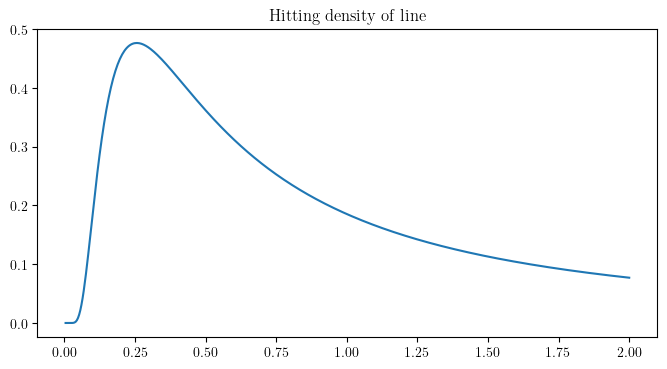

In [28]:
t = np.linspace(0,T,N)

g1 = gamma1_Q(t[1:],x0,y0)
plt.plot(t[1:],g1)
print(np.sum(g1)*(t[3]-t[2]))
plt.title("Hitting density of line");



In [29]:
# Compute the initial value of the one-touch call option.

g1 = gamma1_Q(t[1:],x0,y0)
C0 = np.sum(g1*(t[3]-t[2]))*np.exp(-r*T)

display(Latex(f"Initial value of one-touch call option: {C0}"))


<IPython.core.display.Latex object>

Probability of not hitting line:  0.55103987882145
Initial value of x0:  0.40464311358790916
Final value of line on Brownian scale:  1.650374439011456
Probability of hitting line:  0.448960121172934
Total probability:  0.999999999994384


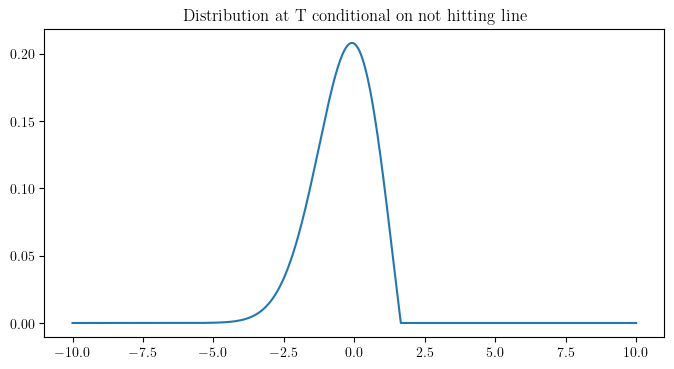

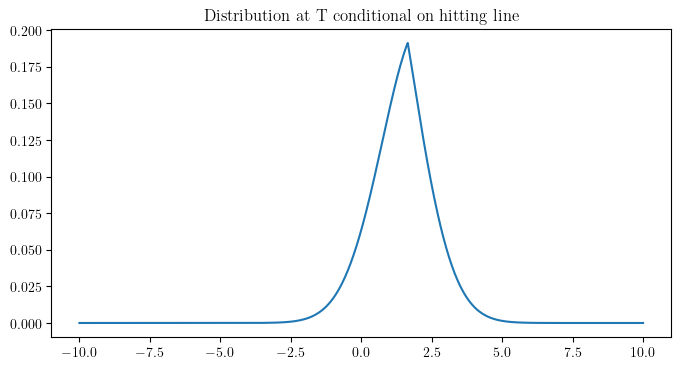

In [30]:
def gamma2_Q(t,x,y,z):
    return ((gamma0(t,x,z)-integrate.quad_vec(lambda u: gamma1_Q(u,x,y)*gamma0(t-u,y+beta_Q*u,z),0,t)[0]))

def gamma2_Qbar(t,x,y,z):
    return ((gamma0(t,x,z)-integrate.quad_vec(lambda u: gamma1_Qbar(u,x,y)*gamma0(t-u,y+beta_Qbar*u,z),0,t)[0]))

z = np.linspace(-10,10,1000)
g2 = gamma2_Qbar(T,x0,y0,z)
plt.plot(z,g2)
plt.title("Distribution at T conditional on not hitting line")
print("Probability of not hitting line: ",np.sum(g2)*(z[3]-z[2]))

print("Initial value of x0: ", x0)
print("Final value of line on Brownian scale: ",y0+beta_Qbar*T)

plt.figure()

g3 = gamma0(T,x0,z)-gamma2_Qbar(T,x0,y0,z)
plt.plot(z,g3)
plt.title("Distribution at T conditional on hitting line");

print("Probability of hitting line: ",np.sum(g3)*(z[3]-z[2]))

print("Total probability: ", np.sum(g2)*(z[3]-z[2]) + np.sum(g3)*(z[3]-z[2]))


We have
$$
S_T(\omega) = \exp\left\{ \sigma\left( x_0 + B_T^{\mathbb{Q}}(\omega) - \beta_{\mathbb{Q}} T\right)\right\}
$$
where $x_0 = (\log(S_0) + rT)/\sigma$ and $\beta_{\mathbb{Q}} = \sigma/2$, and thus
$$
S_T(\omega) = \exp\left\{ \sigma\left( x_0 + B_T^{\overline{\mathbb{Q}}}(\omega) - \beta_{\overline{\mathbb{Q}}} T\right)\right\}
$$
where $B_T^{\overline{\mathbb{Q}}}(\omega)$ is the Brownian motion under the measure $\overline{\mathbb{Q}}$ and $\beta_{\overline{\mathbb{Q}}} = \sigma/2-\theta/p$.

Further, using $B_t^{\mathbb{Q}}(\omega) = B_t^{\overline{\mathbb{Q}}}(\omega) + \theta/p t = B_t(\omega) + \theta t$, we can write:
$$
\begin{align*}
\xi_T(\omega) & = \exp\left\{ \frac{\theta}{p} B_T + \left( r + \frac{1}{2}\theta^2(2p^{-1}-p^{-2})\right) T\right\} \\
& = \exp\left\{ \frac{\theta}{p} B_T^{\mathbb{Q}}(\omega) + \left( r - \frac{1}{2}\theta^2 p^{-2}\right) T\right\} \\
& = \exp\left\{ \frac{\theta}{p} B_T^{\overline{\mathbb{Q}}}(\omega) + \left( r + \frac{1}{2}\theta^2 p^{-2}\right) T\right\}
\end{align*}
$$
We conclude that 
$$
\sup_{0 \le t \le T} J_t^\zeta = 
\begin{cases}
e^{-rT} \exp\left\{ -\frac{\theta}{p} B_T^{\overline{\mathbb{Q}}}(\omega) - \left( r + \frac{1}{2}\theta^2 p^{-2}\right) T\right\}\left(\frac{1}{B} \exp\left\{ \sigma\left( x_0 + B_T^{\overline{\mathbb{Q}}}(\omega) - \beta_{\overline{\mathbb{Q}}} T\right)\right\} - \alpha\right)_+, & \text{if } T < H_B \\
0, & \text{if } H_B \le T.
\end{cases}
$$
Or equivalently, the first case occurs if $\tilde{x} + B_t^{\overline{\mathbb{Q}}}(\omega) < \tilde{y} + \tilde{\beta}_{\overline{\mathbb{Q}}} t$ for all $t \le T$.

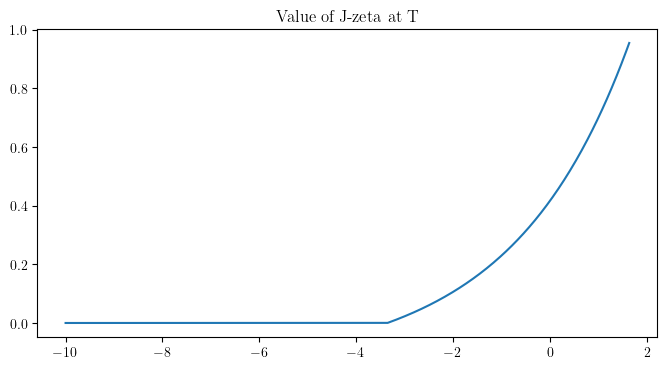

In [31]:
# Define a function $J$ which is the value of the supremum above for given value of $B_T$, given $T<H_B$

def J(BT, T, x0):
    return (np.exp(-theta/p*BT-(theta**2/p**2/2 + 2*r)*T)*
            np.maximum(0, np.exp(sigma*(x0+BT-beta_Qbar*T))/B-alpha))

plt.plot(z[z<B_y],J(z[z<B_y],T,x0))
plt.title("Value of J-zeta at T");


We can compute the minimum initial wealth requirement to hold a short position in the one-touch call option, given the initial wealth $w_0$ and the price gap $\Delta C$ as follows:

$$
w_{min} = \mathbb{E}^{\overline{\mathbb{Q}}}\left[\sup_{0 \le t \le T} J_t^\zeta\right] - \Delta C.
$$

Moreover, the optimal terminal wealth is given by:
$$W_T^{\pi,C} = \xi_T \left(M \vee \left(\sup_{0 \le t \le T} J_t^\zeta \right) \right)$$
where $M$ is chosen such that
$$H(M) := \mathbb{E}^{\bar{\mathbb{Q}}}\left[{\left( \sup_{0 \le u \le T} J_u^\zeta\right) \vee M}\right] = w_0 + \Delta C.$$

In [32]:
# Compute the minimal initial wealth requirement to hold a short position in the one-touch call option:

g2_Qbar = gamma2_Qbar(T,x0,y0,z)*(z[3]-z[2])

w_min = np.sum(g2_Qbar[z<B_y]*J(z[z<B_y],T,x0))-DC
display(Latex(f"Minimum initial wealth requirement to hold a short position in the one-touch call option: {w_min}"))


<IPython.core.display.Latex object>

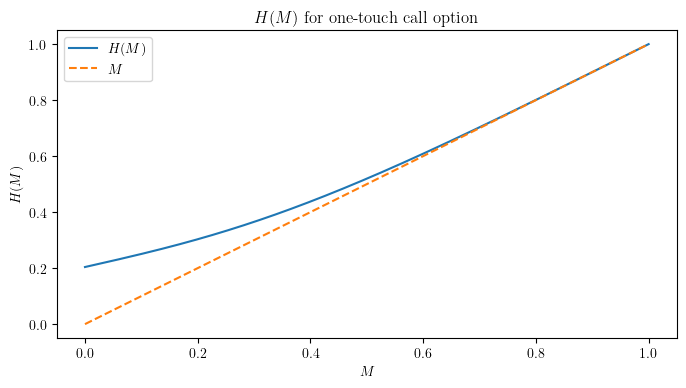

In [33]:
# Compute H(M)

p_nohit = 1-np.sum(g2_Qbar[z<B_y])
def H_Qbar(M):
    return M + np.sum(g2_Qbar[z<B_y]*np.maximum(J(z[z<B_y],T,x0)-M,0))

M_vec = np.linspace(0.0,1.0,501)
H_vec = np.zeros(np.size(M_vec))
for i in range(np.size(M_vec)):
    H_vec[i] = H_Qbar(M_vec[i])

plt.plot(M_vec,H_vec,label=r"$H(M)$")
plt.plot(M_vec,M_vec,'--',label=r"$M$")
plt.xlabel(r"$M$")
plt.ylabel(r"$H(M)$")
plt.legend()
plt.title(r"$H(M)$ for one-touch call option");

In [34]:
# Compute the CDF of $\bar{Y}_T$.

w0 = H_vec - DC
z2 = np.linspace(0, 1.0, 501)
NN = np.size(w0)
yN = np.zeros((NN,np.size(z2)))
p0 = g2_Qbar[z<B_y]
z0 = z[z<B_y]
J0 = J(z0,T,x0)
uN = np.zeros(NN)

def Exp_u(z,p):
    return np.dot(np.diff(p),(u(z[1:])+u(z[:-1]))/2)

for i in range(NN):
    for j in range(np.size(z2)):
        yN[i,j] = (1-np.sum(p0[J0>np.maximum(M_vec[i],z2[j])]))*(M_vec[i] <= z2[j])
    uN[i] = Exp_u(z2,yN[i,:])


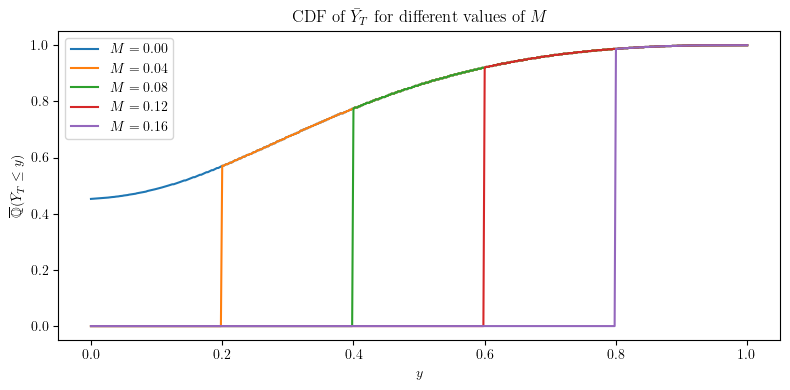

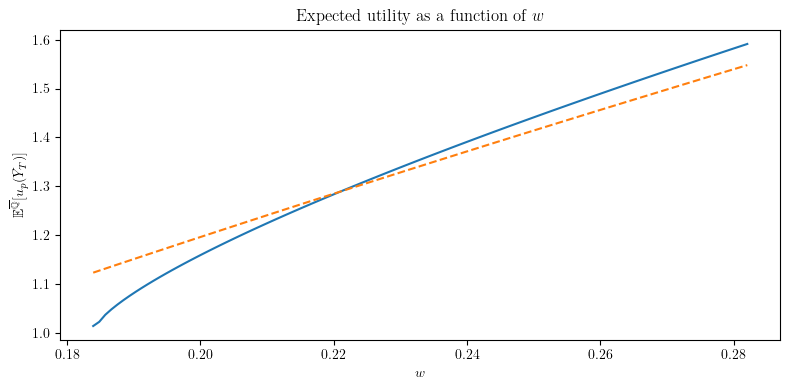

In [35]:

plt.plot(z2,yN[0,:],z2,yN[100,:],z2,yN[200,:],z2,yN[300,:],z2,yN[400,:])
plt.xlabel(r"$y$")
plt.ylabel(r"$\overline{\mathbb{Q}}(\bar{Y}_T \leq y)$")
plt.title(r"CDF of $\bar{Y}_T$ for different values of $M$")
plt.legend([r"$M={0:.2f}$".format(M_vec[i]) for i in np.arange(0,NN,20)])

plt.tight_layout()
plt.savefig(plot_folder+"CDF_YT_Qbar.pdf", bbox_inches='tight')
plt.show() 

nn = 100
plt.plot(w0[:nn],uN[:nn],label=r"$\mathbb{E}^{\overline{\mathbb{Q}}}[u_p(\bar{Y}_T)]$")
plt.plot(w0[:nn],u(w0[:nn]),'--',label=r"$u(w)$")
plt.xlabel(r"$w$")
plt.ylabel(r"$\mathbb{E}^{\overline{\mathbb{Q}}}[u_p(\bar{Y}_T)]$")
plt.title(r"Expected utility as a function of $w$")
plt.tight_layout()


Now we turn to the case where the trader also takes a static position in the Hobson super-hedge with long position in (B-K) units of the call option with strike $K$, where $K<B$. 

In this case, we can compute the intrinsic value of the one-touch call option at time $t \le T$ as:
$$\mathcal{I}_t(-C_T^o+ \tilde{C}_T^o) =
\begin{cases}
\frac{(S_T - K)_+}{B_K} & \text{if } t = T < H_B\\
\frac{(D_T K- D_t S_t)_+}{D_t(B-K)} & \text{if } H_B \le t \le T\\
0 & \text{if } t < T \wedge H_B
\end{cases}.
$$


In this case, we have a different expression for $\zeta^0_t$:
$$\zeta^0_t = 
\begin{cases}
\varphi^*(t) := D_t^{-1}\xi_t^{-1}\left(\mathbb{E}^\mathbb{Q}\left[D_T (\tilde{C}^o_T - C_T^o)|\mathcal{F}_t\right]-\alpha\right) & \text{if } t = H^* < T\\
\xi_T^{-1}\left[\frac{(S_T- K)_+}{B-K} - \alpha D_T^{-1}\right]_+ & \text{if } t = T- < H_B\\
0 & \text{if } t = T
\end{cases}.
$$
Here $H^*$ is the first hitting time of the line $D_t S_t = D_T K$ after the time $H_B$.

To begin our analysis, we compute the functions $\varphi^*(t)$ and the law of $H^*$ under $\overline{\mathbb{Q}}$.

Note that on the set $t>H_B$, we have $\tilde{C}^o_T - C_T^o = \frac{(K - S_T)_+}{B-K}$.


To compute the hitting time of the line $D_t S_t = D_T K$, conditional on starting at the line $D_{u} S_{u} = D_T B$, we can use the same hitting law computations as above, but now with initial value $\hat{x} = \log(B)/\sigma$, and $\hat{y} = \log(K)/\sigma$ and $\beta_{\bar{\mathbb{Q}}} = \sigma/2 - \theta/p$ as before. Note however that now $\hat{x} > \hat{y}$, so the direction of the line relative to the Brownian motion is reversed.

Probability of hitting $B$ before T: 0.449292694839386


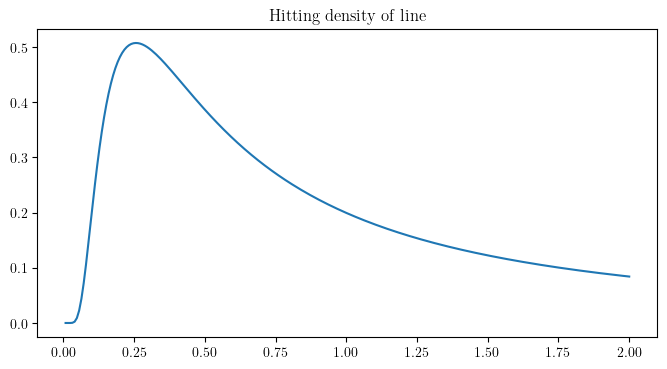

In [36]:
N = 250
t = np.linspace(0,T,N+1)

g1 = gamma1_Qbar(t[1:],x0,y0)
plt.plot(t[1:],g1)
print("Probability of hitting $B$ before T:", np.sum(g1)*(t[3]-t[2]))
plt.title("Hitting density of line");


In [37]:
HD = np.zeros((N,N))

for i in range(N-1):
    HD[i,i:] = gamma1_Qbar(t[i+1:]-t[i],xhat,yhat)*(t[3]-t[2])*g1[i]


Probability of hitting $K$ after $B$ before T: 0.23811727150682652


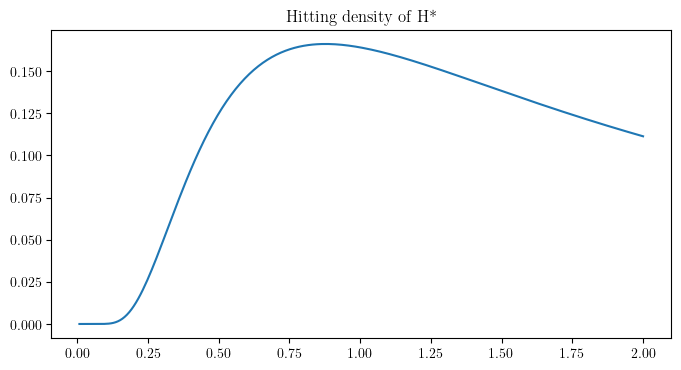

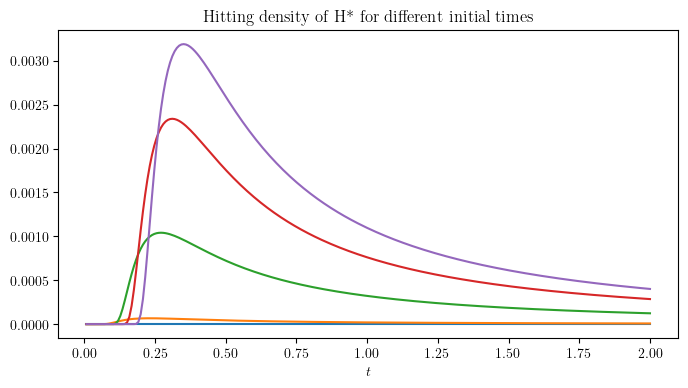

In [38]:

plt.plot(t[1:],np.sum(HD,axis=0))
plt.title("Hitting density of H*");

print("Probability of hitting $K$ after $B$ before T:", np.sum(np.sum(HD,axis=0))*(t[3]-t[2]))

plt.figure()
plt.plot(t[1:],HD[0,:],t[1:],HD[5,:],t[1:],HD[10,:],t[1:],HD[15,:],t[1:],HD[20,:]);

plt.title("Hitting density of H* for different initial times");
plt.xlabel(r"$t$");

To compute the term $\mathbb{E}^\mathbb{Q}\left[D_T (\tilde{C}^o_T - C_T^o)|\mathcal{F}_t\right]$ at the time when $D_t S_t = D_T K$, we can use the Black-Scholes formula for the price of the call option, and the fact that at the money calls and puts are the same price, to see that:
$$
\mathbb{E}^\mathbb{Q}\left[D_T (\tilde{C}^o_T - C_T^o)|\mathcal{F}_t\right] = \frac{D_t}{B-K} BS(K, K e^{-r(T-t)}, \sigma, r, T-t)
$$

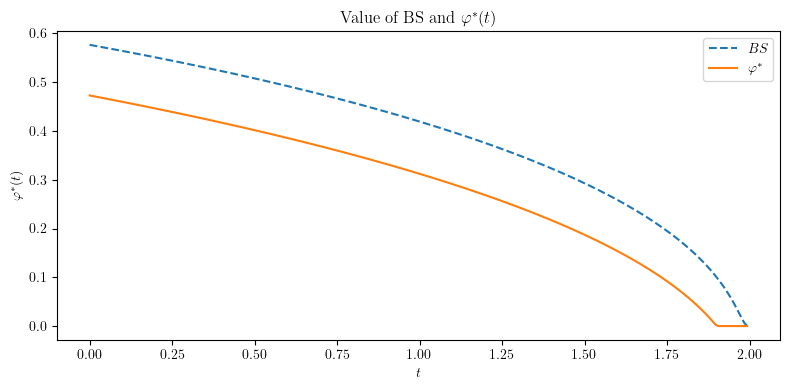

In [39]:
bs = np.exp(-r*t[:-1])*BS(K,K*np.exp(-r*(T-t[:-1])),sigma,r,T-t[:-1])/(B-K)

plt.plot(t[:-1],bs,'--',label=r"$BS$")

phi_star = (np.exp(r*t[:-1]) * np.maximum(bs-alpha, 0) * 
            (K * np.exp(-r*T)/S0)**(-theta/p/sigma) * 
            np.exp(-t[:-1]*(r + theta*sigma/p/2-theta**2/p**2/2)))

plt.plot(t[:-1],phi_star,label=r"$\varphi^*$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\varphi^*(t)$")
plt.title(r"Value of BS and $\varphi^*(t)$")
plt.legend()
plt.tight_layout()
plt.savefig(plot_folder+"OptimalStrategy.pdf", bbox_inches='tight')

Probability of not hitting line:  0.55103987882145


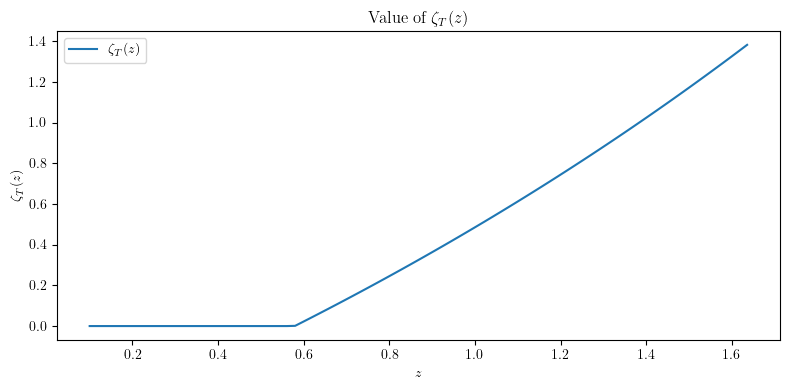

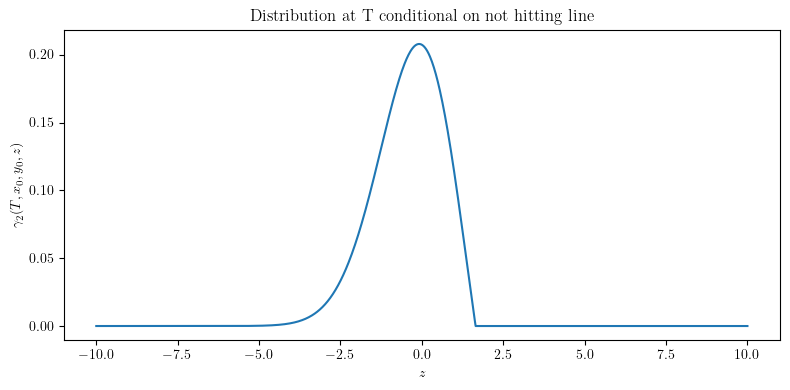

In [40]:
def ST(z):
    return np.exp(sigma*(x0 + z - beta_Qbar*T))

def xiT(z):
    return np.exp(theta/p*z + (r+theta**2/p**2/2)*T)

def zeta_T(z):
    return np.maximum(0, (ST(z)-K)/(B-K) - alpha*np.exp(r*T)) / xiT(z)

zz = np.linspace(0.1, 2.0, 100)
plt.plot(zz[zz<B_y], zeta_T(zz[zz<B_y]), label=r"$\zeta_T(z)$")

plt.xlabel(r"$z$")
plt.ylabel(r"$\zeta_T(z)$")
plt.title(r"Value of $\zeta_T(z)$")
plt.legend()
plt.tight_layout()

plt.figure()

g2 = gamma2_Qbar(T,x0,y0,z)
plt.plot(z,g2)
plt.title("Distribution at T conditional on not hitting line")
print("Probability of not hitting line: ",np.sum(g2)*(z[3]-z[2]))

plt.xlabel(r"$z$")
plt.ylabel(r"$\gamma_2(T,x_0,y_0,z)$")
plt.tight_layout()



Probability of hitting first line but not second line:  0.210842849671724


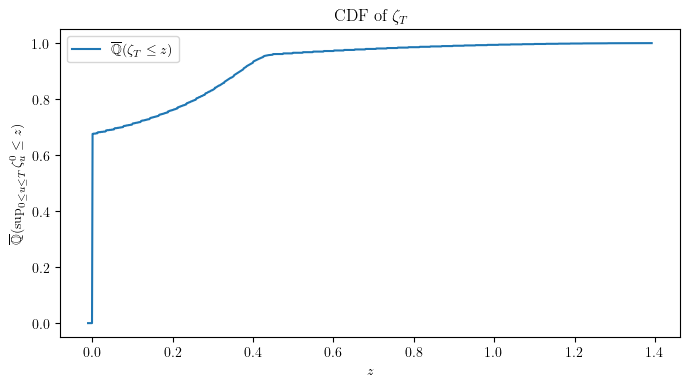

In [41]:
zeta_max = np.maximum(np.max(zeta_T(zz[zz<B_y])),np.max(phi_star))
eps = 0.01
zeta = np.linspace(-eps, zeta_max+eps, 1000)

phi_distn = np.sum(HD,axis=0)*(t[3]-t[2])
z_distn = g2*(z[3]-z[2])

zeta_T_val = zeta_T(z)

p_other = 1-np.sum(phi_distn)-np.sum(z_distn)


print("Probability of hitting first line but not second line: ", p_other)

Qzeta = np.zeros(np.size(zeta))

for i in range(np.size(zeta)):
    Qzeta[i] = (np.sum(phi_distn[phi_star <= zeta[i]]) 
                + np.sum(z_distn[zeta_T_val <= zeta[i]]) 
                + (zeta[i] >= 0) * p_other)

plt.plot(zeta, Qzeta, label=r"$\overline{\mathbb{Q}}(\zeta_T \leq z)$")
plt.xlabel(r"$z$")
plt.ylabel(r"$\overline{\mathbb{Q}}(\sup_{0 \le u \le T} \zeta_u^0 \leq z)$")
plt.title(r"CDF of $\zeta_T$")
plt.legend();

Minimum wealth requirement:  0.104054995868908


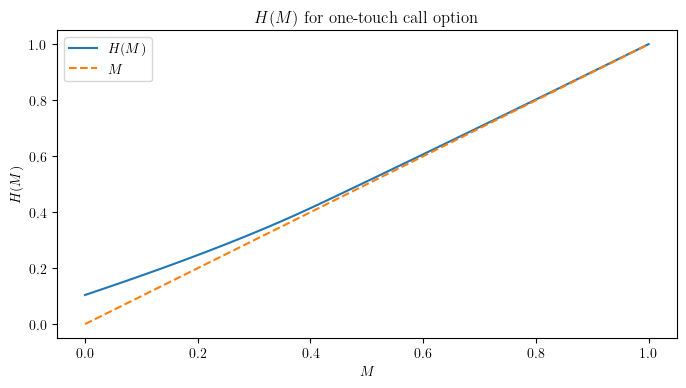

In [42]:
def H_Qbar_zeta(M):
    return (M + np.sum(phi_distn * np.maximum(phi_star - M, 0)) 
            + np.sum(z_distn * np.maximum(zeta_T_val - M, 0)))

print("Minimum wealth requirement: ", H_Qbar_zeta(0))

H_vec_zeta = np.zeros(np.size(M_vec))
for i in range(np.size(M_vec)):
    H_vec_zeta[i] = H_Qbar_zeta(M_vec[i])

plt.plot(M_vec,H_vec_zeta,label=r"$H(M)$")
plt.plot(M_vec,M_vec,'--',label=r"$M$")
plt.xlabel(r"$M$")
plt.ylabel(r"$H(M)$")
plt.legend()
plt.title(r"$H(M)$ for one-touch call option");

In [43]:
w0_zeta = H_vec_zeta - DC

NN = np.size(w0_zeta)
uN_zeta = np.zeros(NN)

for i in range(NN):
    uN_zeta[i] = (np.dot(u(np.maximum(M_vec[i],phi_star)),phi_distn) 
                  + np.dot(u(np.maximum(M_vec[i],zeta_T_val)),z_distn) 
                  + u(np.maximum(M_vec[i],0)) * p_other)


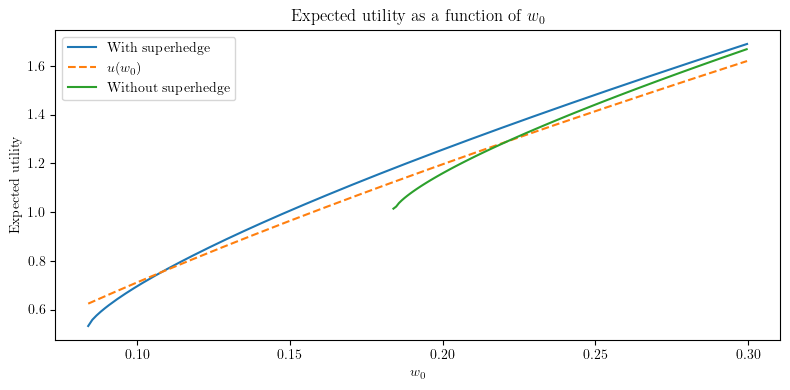

In [ ]:
w_bar = 0.3

plt.plot(w0_zeta[w0_zeta<w_bar],uN_zeta[w0_zeta<w_bar],label=r"With superhedge")
plt.plot(w0_zeta[w0_zeta<w_bar],u(w0_zeta[w0_zeta<w_bar]),'--',label=r"$u(w_0)$")
plt.plot(w0[w0<w_bar],uN[w0<w_bar],label=r"Without superhedge")

plt.xlabel(r"$w_0$")
plt.ylabel(r"Expected utility")
plt.title(r"Expected utility as a function of $w_0$")
plt.legend()
plt.tight_layout()
plt.savefig(plot_folder+"ExpectedUtility_OTWithWithoutSH.pdf", bbox_inches='tight')


In [45]:
# Define a range of K values
K_values = np.linspace(0.8, B - 0.4, 20)  # Ensure K < B
M_vec = np.linspace(0.0,0.5,501)
min_wealths = np.zeros(len(K_values))
expected_utilities = np.zeros((len(K_values), np.size(M_vec)))
wN = np.zeros((len(K_values), np.size(M_vec)))
N = 100 # Used for computation of hitting density
t = np.linspace(0,T,N+1)
i = 0
w_feas = np.zeros(len(K_values))
w_utility = np.zeros(len(K_values))


for K in tqdm(K_values):
    # Update yhat based on the current K
    yhat = np.log(K) / sigma

    # Update computations that depend on K
    bs = (np.exp(-r * t[:-1]) 
          * BS(K, K * np.exp(-r * (T - t[:-1])), sigma, r, T - t[:-1]) 
          / (B - K))
    phi_star = (np.exp(r * t[:-1]) * np.maximum(bs - alpha, 0) 
                * (K * np.exp(-r * T) / S0) ** (-theta / p / sigma) 
                * np.exp(-t[:-1] * (r + theta * sigma / p / 2 - theta ** 2 / p ** 2 / 2)))

    def zeta_T(z):
        return np.maximum(0, (ST(z) - K) / (B - K) - alpha * np.exp(r * T)) / xiT(z)

    zeta_T_val = zeta_T(z)

    # Recompute hitting densities for the updated yhat
    g1 = gamma1_Qbar(t[1:], x0, y0)
    HD = np.zeros((N, N))
    for j in range(N - 1):
        HD[j, j:] = gamma1_Qbar(t[j + 1:] - t[j], xhat, yhat) * (t[3] - t[2]) * g1[j]

    phi_distn = np.sum(HD, axis=0) * (t[3] - t[2])
    z_distn = g2 * (z[3] - z[2])
    p_other = 1 - np.sum(phi_distn) - np.sum(z_distn)

    def H_Qbar_zeta(M):
        return (M + np.sum(phi_distn * np.maximum(phi_star - M, 0)) 
                + np.sum(z_distn * np.maximum(zeta_T_val - M, 0)))

    # Compute the minimum wealth requirement for the current K
    min_wealths[i] = H_Qbar_zeta(0) - DC
    for j in range(np.size(M_vec)):
        wN[i, j] = H_Qbar_zeta(M_vec[j]) - DC
    
    def findM(w,xtol = 1.e-6, rtol = 1.e-6, debug=False, M_min_factor = 10.):
        target = w + DC
        M_R = target
        M_L = 0

        H_R = H_Qbar_zeta(M_R)-target
        if H_R < 0:
            print("Warning: no stochastic effects to numerical tolerance.")
            return M_R

        H_L = H_Qbar_zeta(M_L)-target

        M_mid = (M_L + M_R)/2.
        H_mid = H_Qbar_zeta(M_mid)-target
        if debug:
            print("M: ", M_mid, "H: ", H_mid)
        while np.abs(H_R-H_L) > xtol and np.abs(H_mid) > rtol:
            if H_mid > 0:
                M_R = M_mid
                H_R = H_mid
            else:
                M_L = M_mid
                H_L = H_mid
            M_mid = (M_L + M_R)/2.
            H_mid = H_Qbar_zeta(M_mid)-target
            if debug:
                print("M: ", M_mid, "H: ", H_mid)
        return M_mid
    
    # Find M corresponding to an initial wealth w
    if min_wealths[i] < w:
        w_feas[i] = 1
        M = findM(w, debug=False)
        w_utility[i] = (
            np.dot(u(np.maximum(M, phi_star)), phi_distn)
            + np.dot(u(np.maximum(M, zeta_T_val)), z_distn)
            + u(np.maximum(M, 0)) * p_other
            )
        
        


    # Compute the expected utility for the current K
    for j in range(np.size(M_vec)):
        expected_utilities[i, j] = (
            np.dot(u(np.maximum(M_vec[j], phi_star)), phi_distn)
            + np.dot(u(np.maximum(M_vec[j], zeta_T_val)), z_distn)
            + u(np.maximum(M_vec[j], 0)) * p_other
        )

    i = i + 1


100%|██████████| 20/20 [04:34<00:00, 13.72s/it]


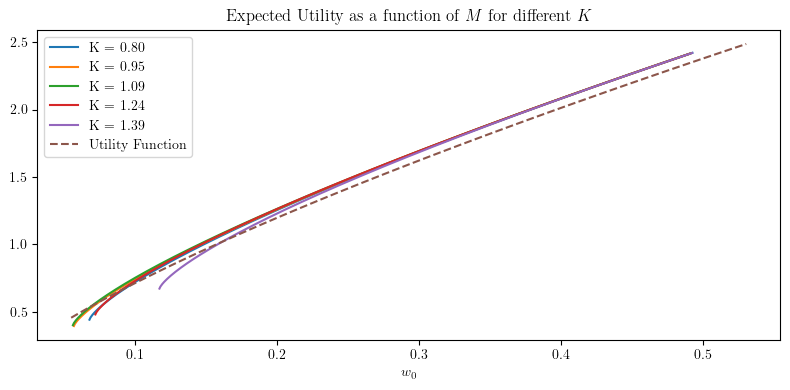

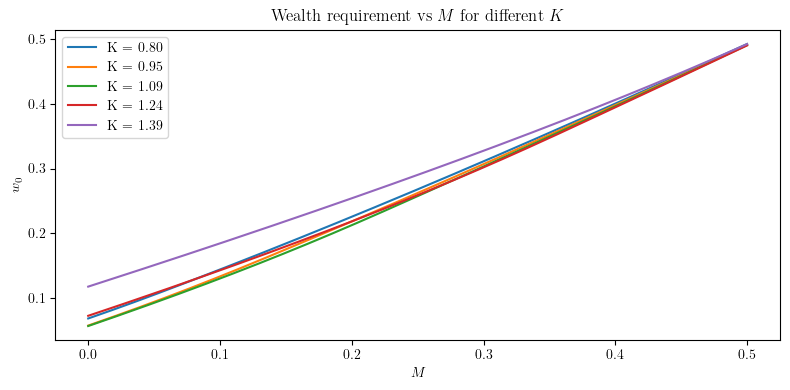

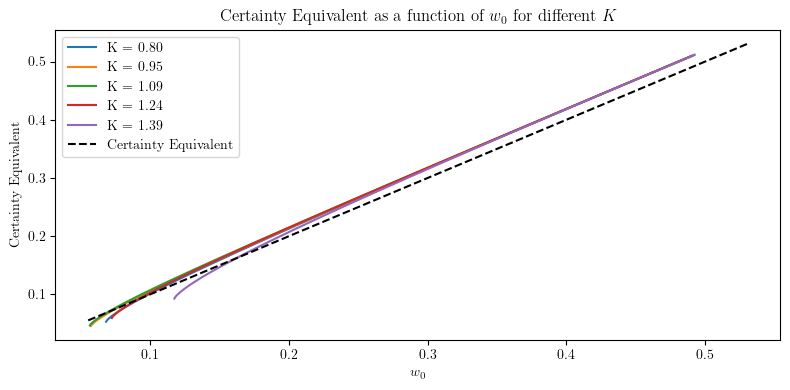

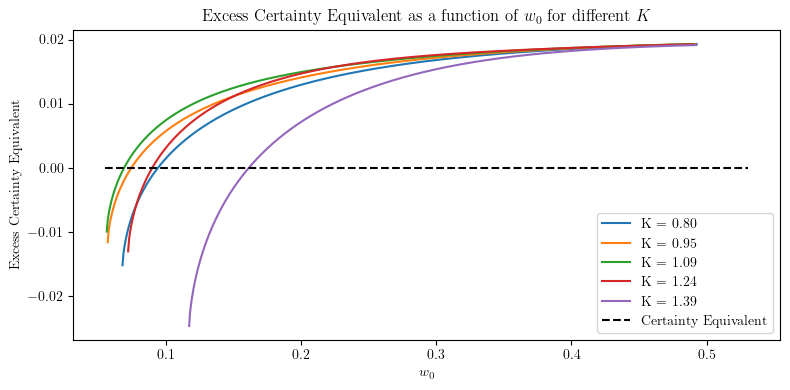

In [ ]:

K_plot_subset = np.arange(0, len(K_values), max(1, len(K_values) // 5))  
    # Select a subset of K values for plotting

# Plot the expected utility as a function of K
for i in K_plot_subset:
    plt.plot(wN[i], expected_utilities[i], label=f"K = {K_values[i]:.2f}")
w_range = np.linspace(np.min(wN), np.max(wN), 100)
plt.plot(w_range, u(w_range), label="Utility Function", linestyle="--")
plt.xlabel(r"$w_0$")
#plt.ylabel(r"$\mathbb{E}^{\overline{\mathbb{Q}}[u_p(\overline{Y}_T)]$")
plt.title(r"Expected Utility as a function of $w_0$ for different $K$")
plt.legend()
plt.tight_layout()
plt.savefig(plot_folder+"ExpectedUtility_vs_M.pdf", bbox_inches='tight')

plt.figure()
for i in K_plot_subset:
    plt.plot(M_vec, wN[i], label=f"K = {K_values[i]:.2f}")
plt.xlabel(r"$M$")
plt.ylabel(r"$w_0$")
plt.title(r"Wealth requirement vs $M$ for different $K$")
plt.legend()
plt.tight_layout()
plt.savefig(plot_folder+"Wealth_vs_M.pdf", bbox_inches='tight')

plt.figure()
for i in K_plot_subset:
    plt.plot(wN[i], u_inv(expected_utilities[i]), label=f"K = {K_values[i]:.2f}")
plt.plot(w_range,w_range, 'k--', label="Certainty Equivalent")
plt.xlabel(r"$w_0$")
plt.ylabel(r"Certainty Equivalent")
plt.title(r"Certainty Equivalent as a function of $w_0$ for different $K$")
plt.legend()
plt.tight_layout()
plt.savefig(plot_folder+"CertaintyEquivalent_vs_M.pdf", bbox_inches='tight')

plt.figure()
for i in K_plot_subset:
    plt.plot(wN[i], u_inv(expected_utilities[i])-wN[i], label=f"K = {K_values[i]:.2f}")
plt.plot(w_range,0*w_range, 'k--', label="Certainty Equivalent")
plt.xlabel(r"$w_0$")
plt.ylabel(r"Excess Certainty Equivalent")
plt.title(r"Excess Certainty Equivalent as a function of $w_0$ for different $K$")
plt.legend()
plt.tight_layout()
plt.savefig(plot_folder+"ExcessCertaintyEquivalent_vs_M.pdf", bbox_inches='tight')

Minimum price: 0.4641138365462332 at K = 1.0210526315789474


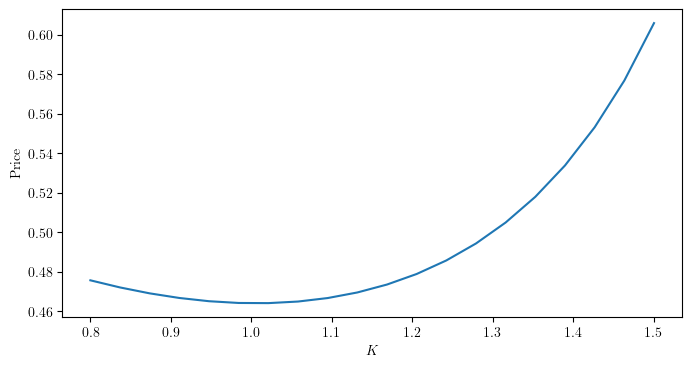

In [47]:
price = BS(K_values, S0, sigma, r, T) / (B - K_values)
plt.plot(K_values, price, label="Hobson-superhedge Price")

plt.xlabel(r"$K$")
plt.ylabel(r"Price")

min_price, min_index = np.min(price), np.argmin(price)

min_K = K_values[min_index]
print(f"Minimum price: {min_price} at K = {min_K}")

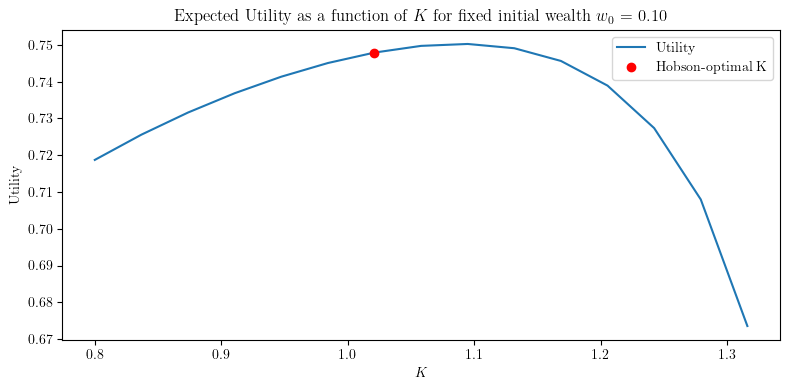

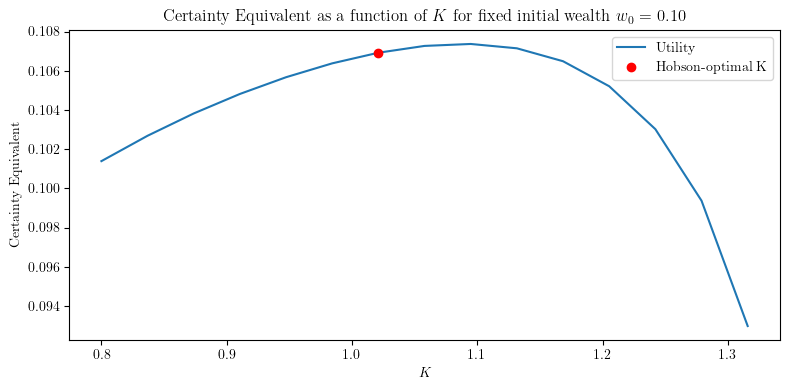

In [48]:
plt.plot(K_values[w_feas==1], w_utility[w_feas==1], label="Utility")
plt.plot(K_values[min_index], w_utility[min_index], 'ro', label="Hobson-optimal K")
plt.xlabel(r"$K$")
plt.ylabel(r"Utility")
plt.title(f"Expected Utility as a function of $K$ for fixed initial wealth $w_0$ = {w:.2f}")   
plt.legend()    
plt.tight_layout()
plt.savefig(plot_folder+"ExpectedUtility_vs_K.pdf", bbox_inches='tight')

plt.figure()
plt.plot(K_values[w_feas==1], u_inv(w_utility[w_feas==1]), label="Utility")
plt.plot(K_values[min_index], u_inv(w_utility[min_index]), 'ro', label="Hobson-optimal K")
plt.xlabel(r"$K$")
plt.ylabel(r"Certainty Equivalent")
plt.title(f"Certainty Equivalent as a function of $K$ for fixed initial wealth $w_0$ = {w:.2f}")   
plt.legend()    
plt.tight_layout()
plt.savefig(plot_folder+"CertaintyEquivalent_vs_K.pdf", bbox_inches='tight')